<a href="https://colab.research.google.com/github/luizklitzke1/ProcessamentoImagensParcial3/blob/main/Processamento_de_Imagens_Parcial_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#Alunos: Arthur B Pinotti, Kaue Reblin, Luiz G Klitzke

import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

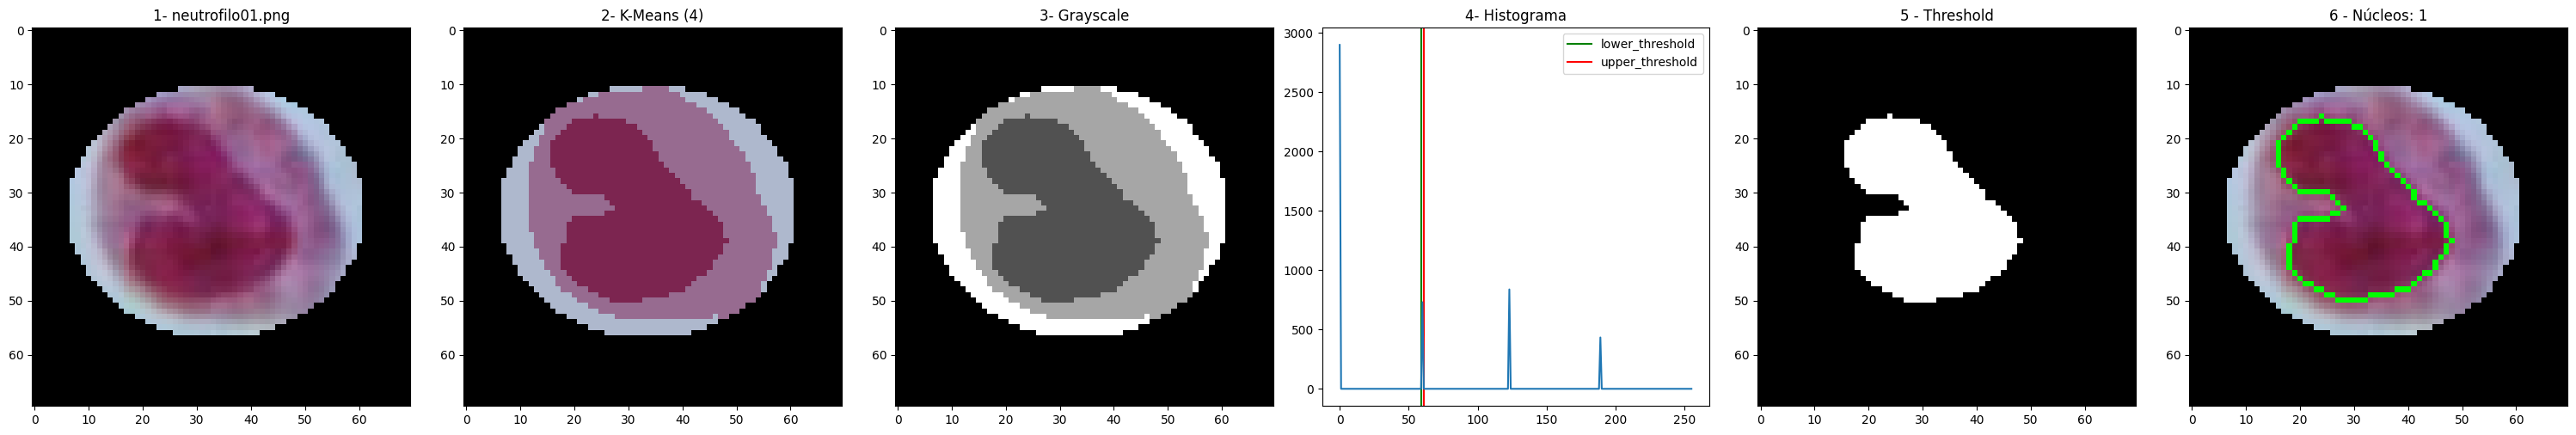

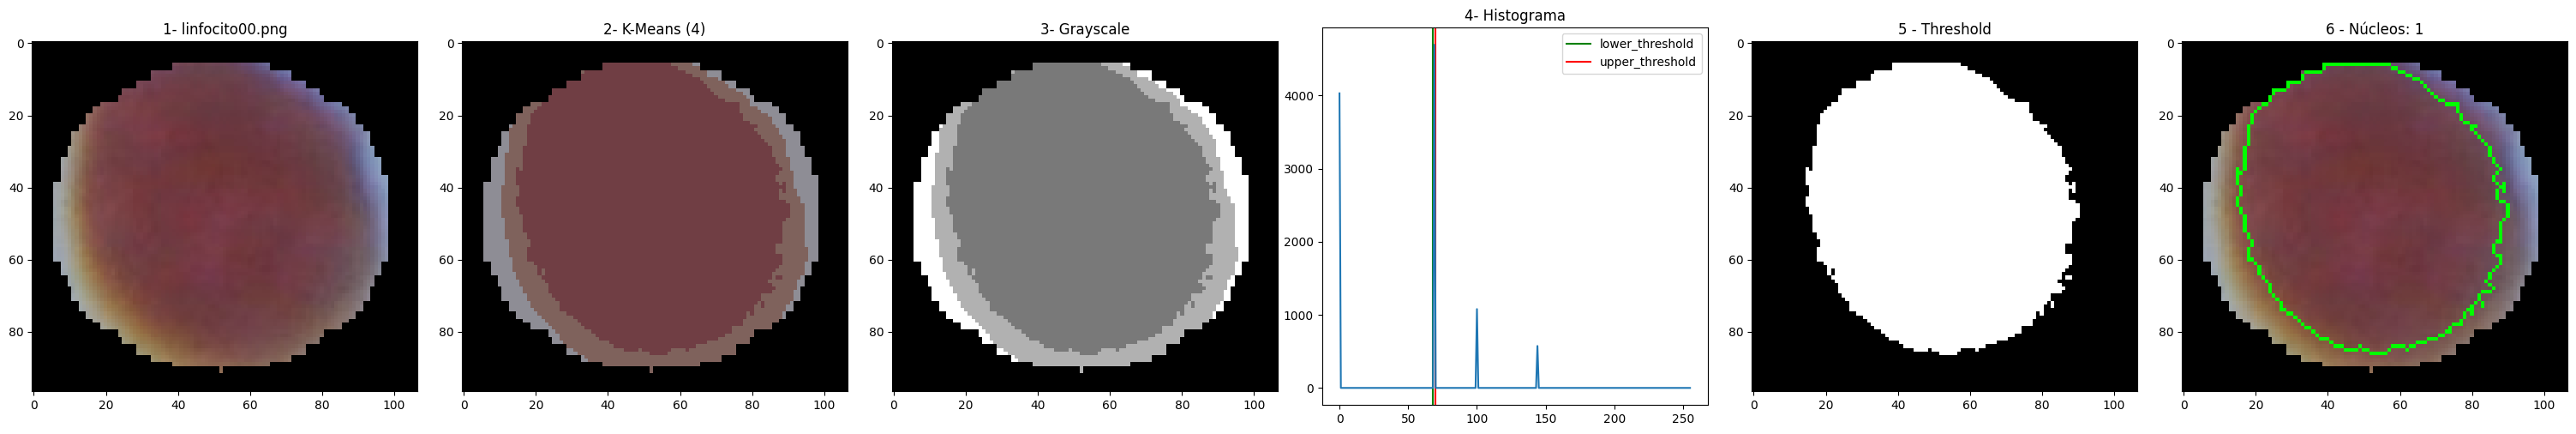

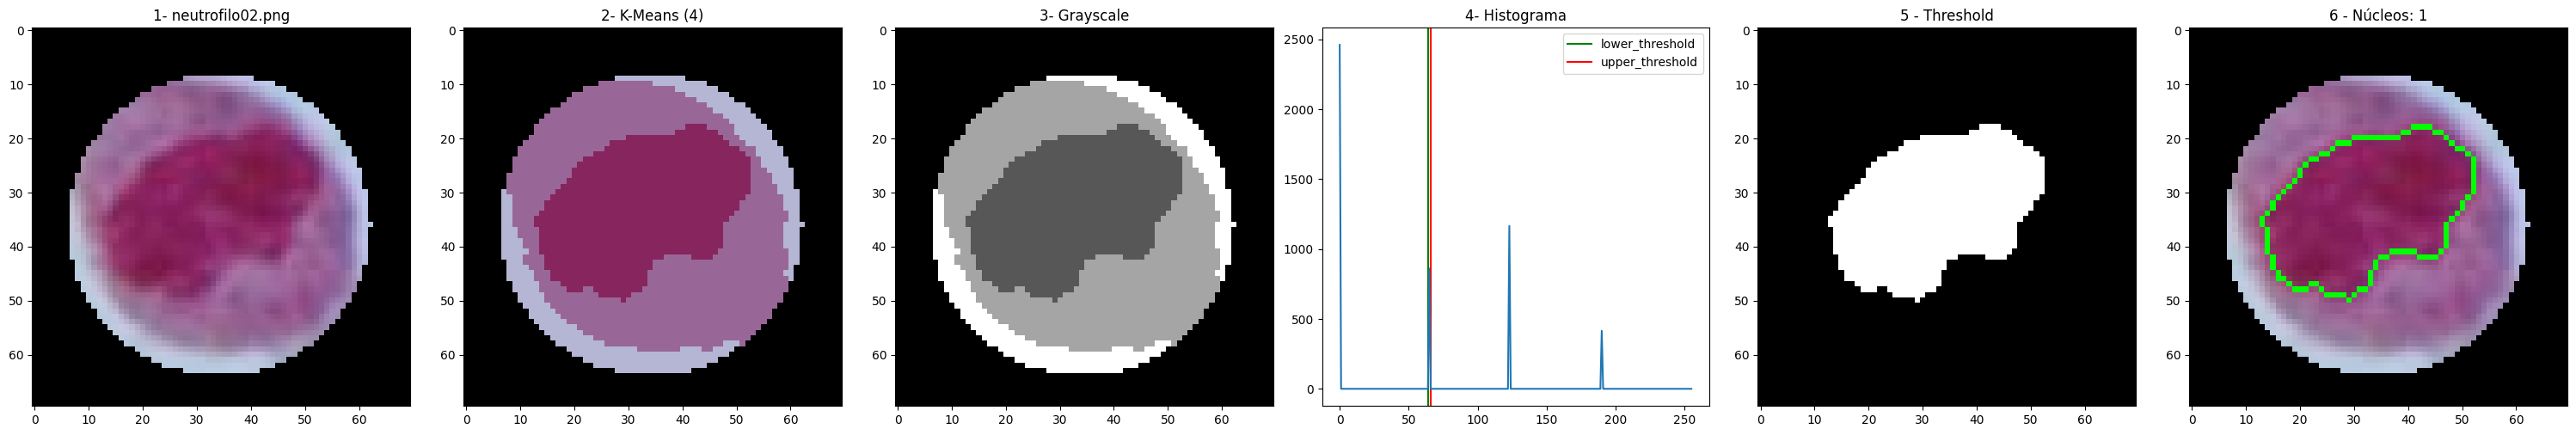

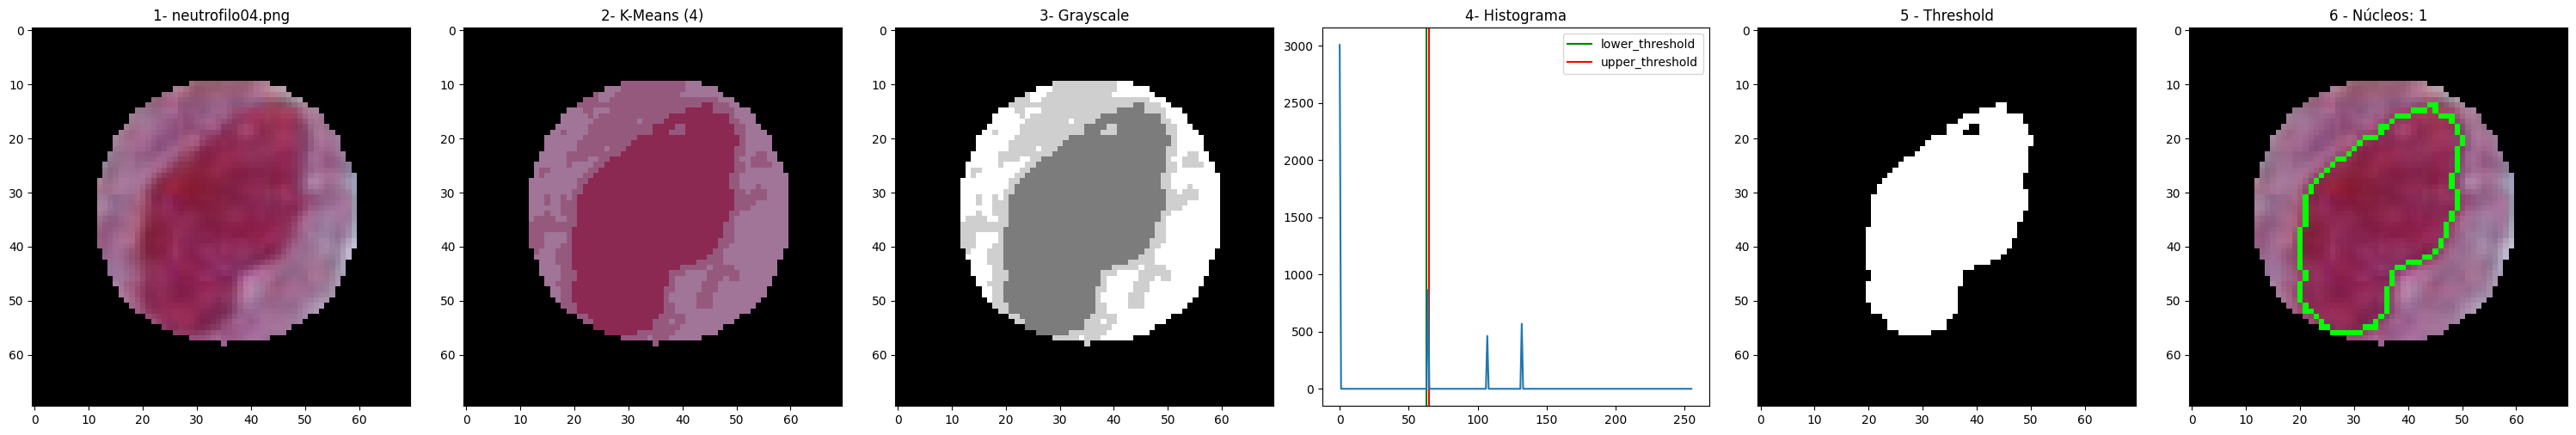

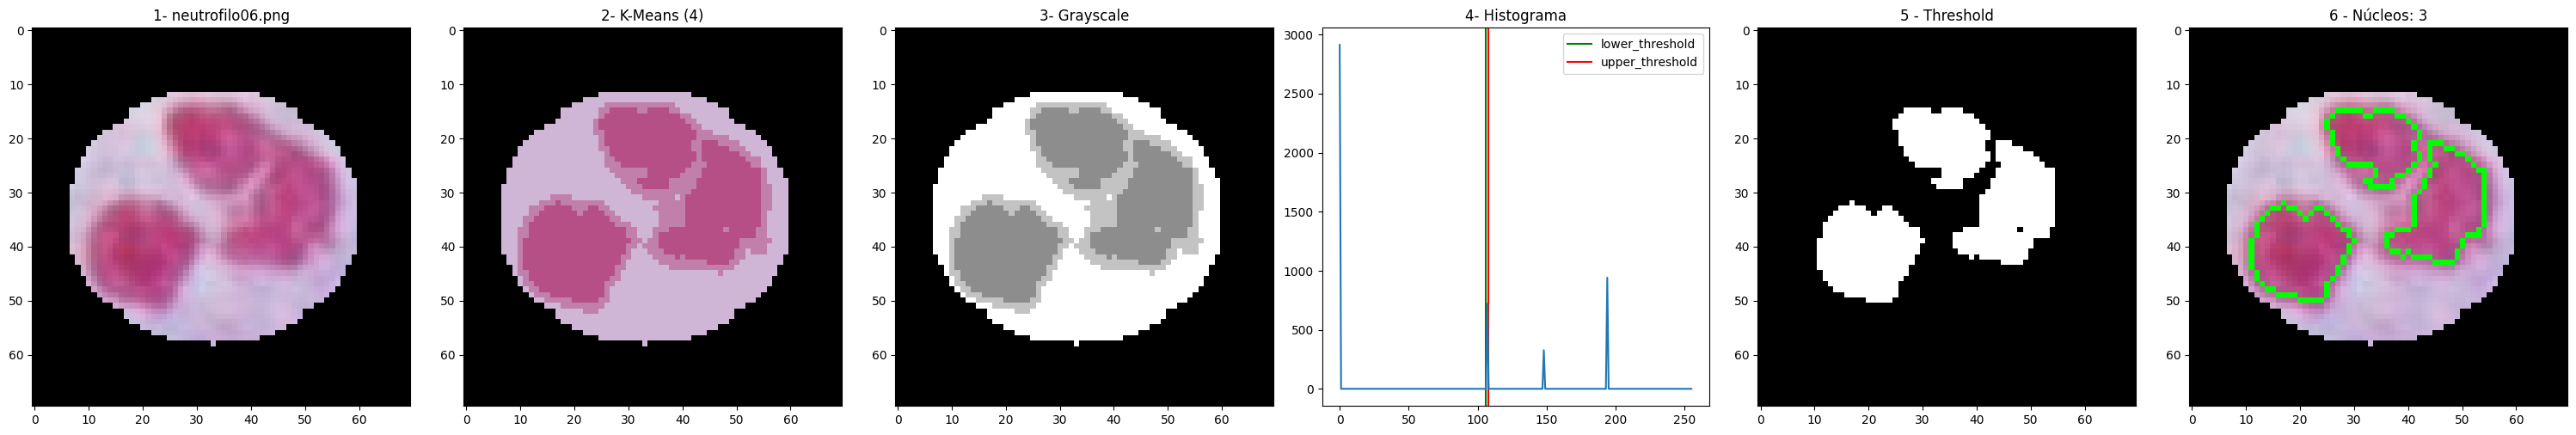

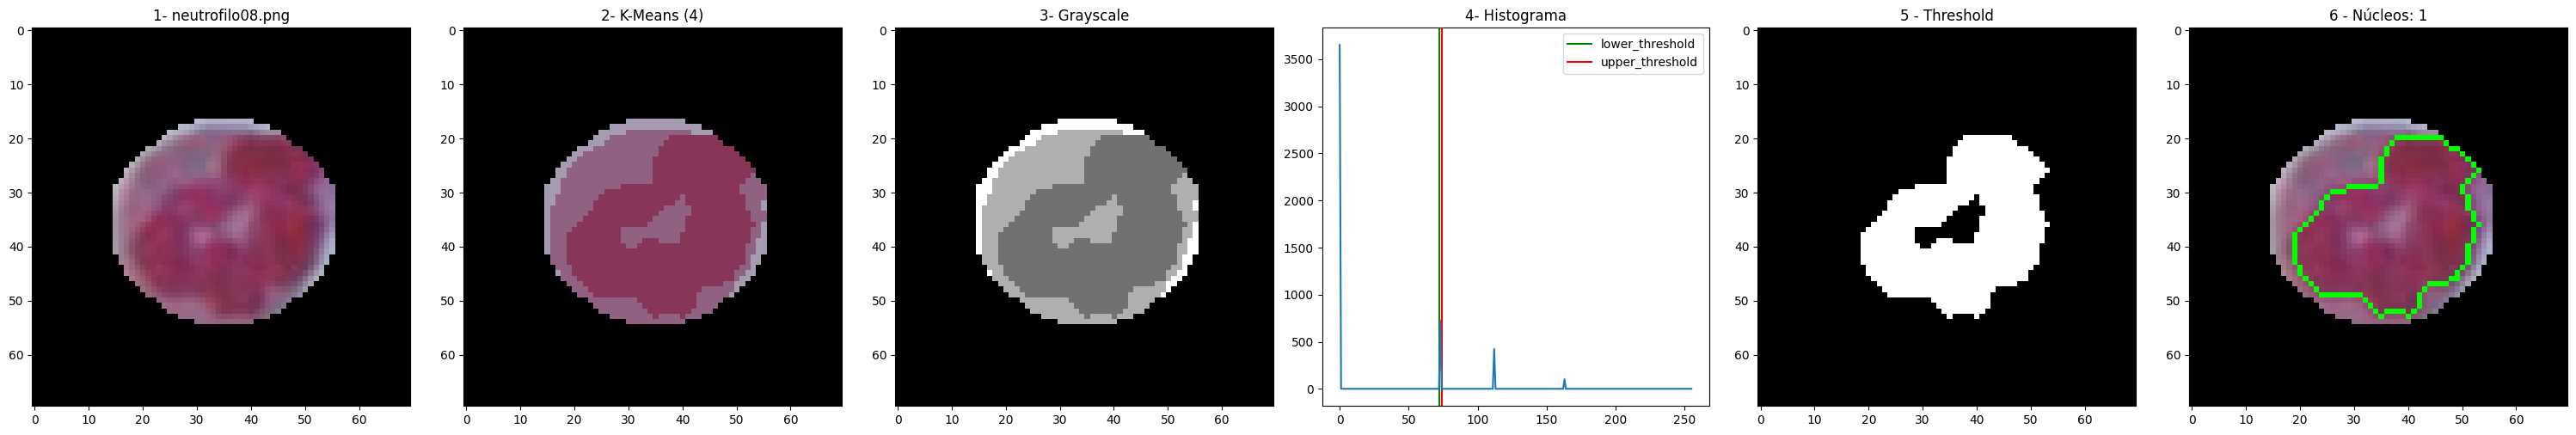

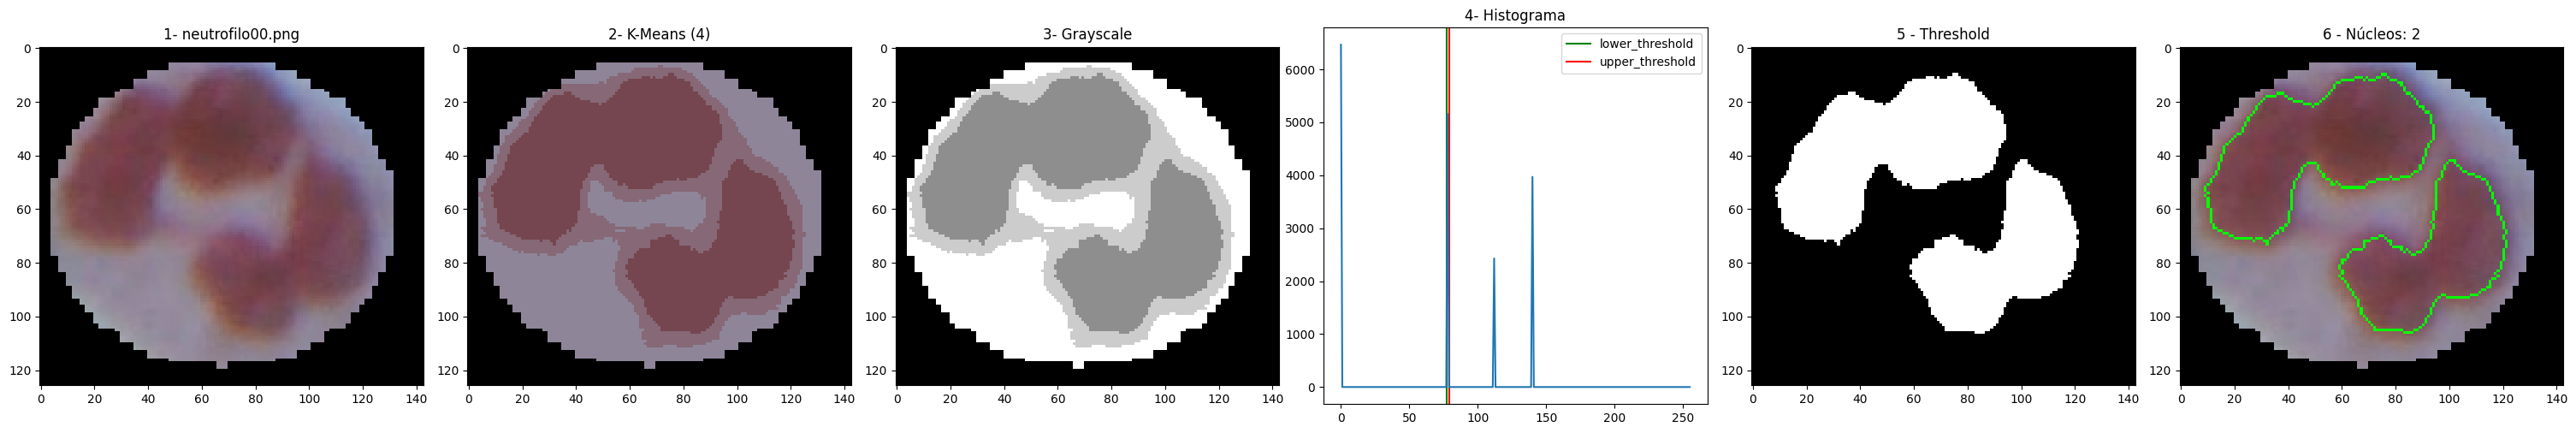

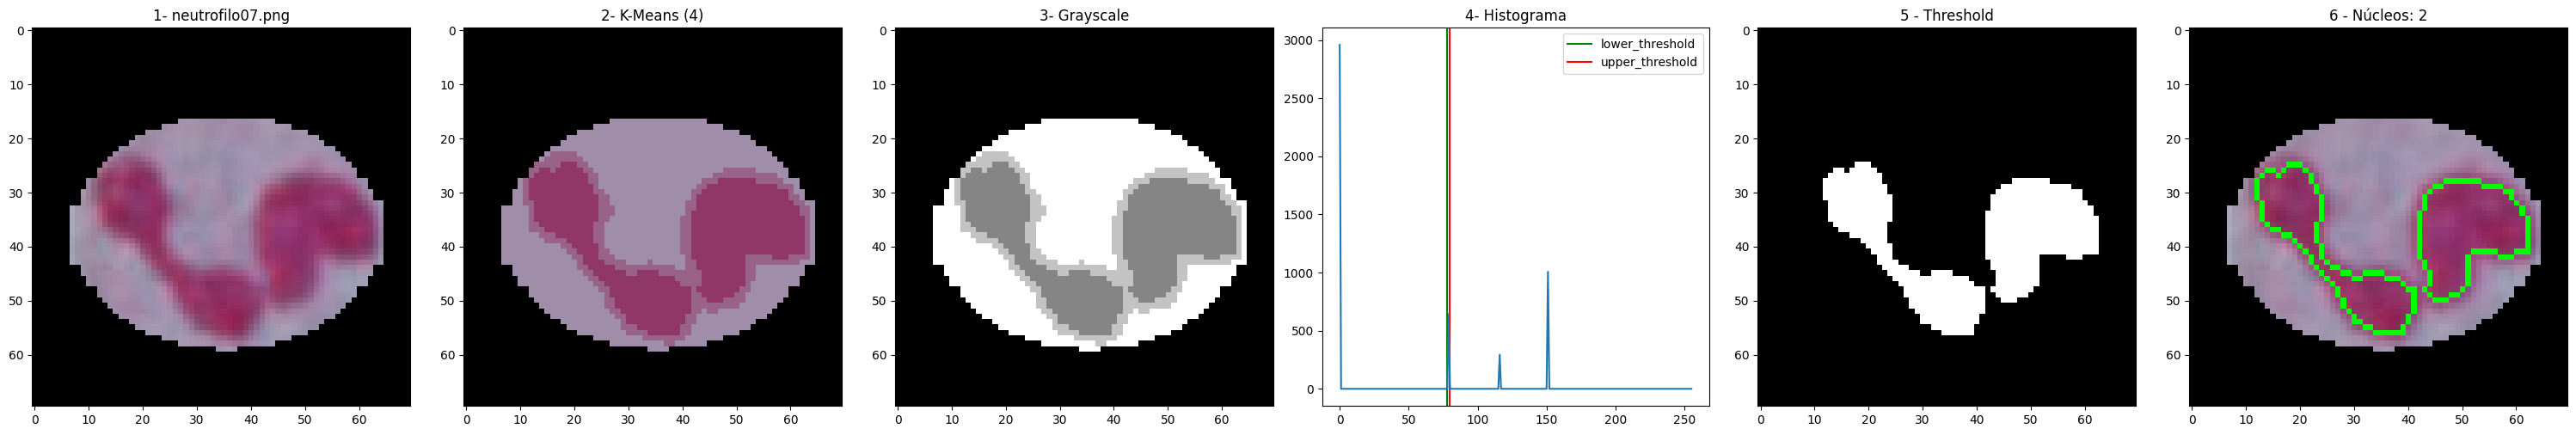

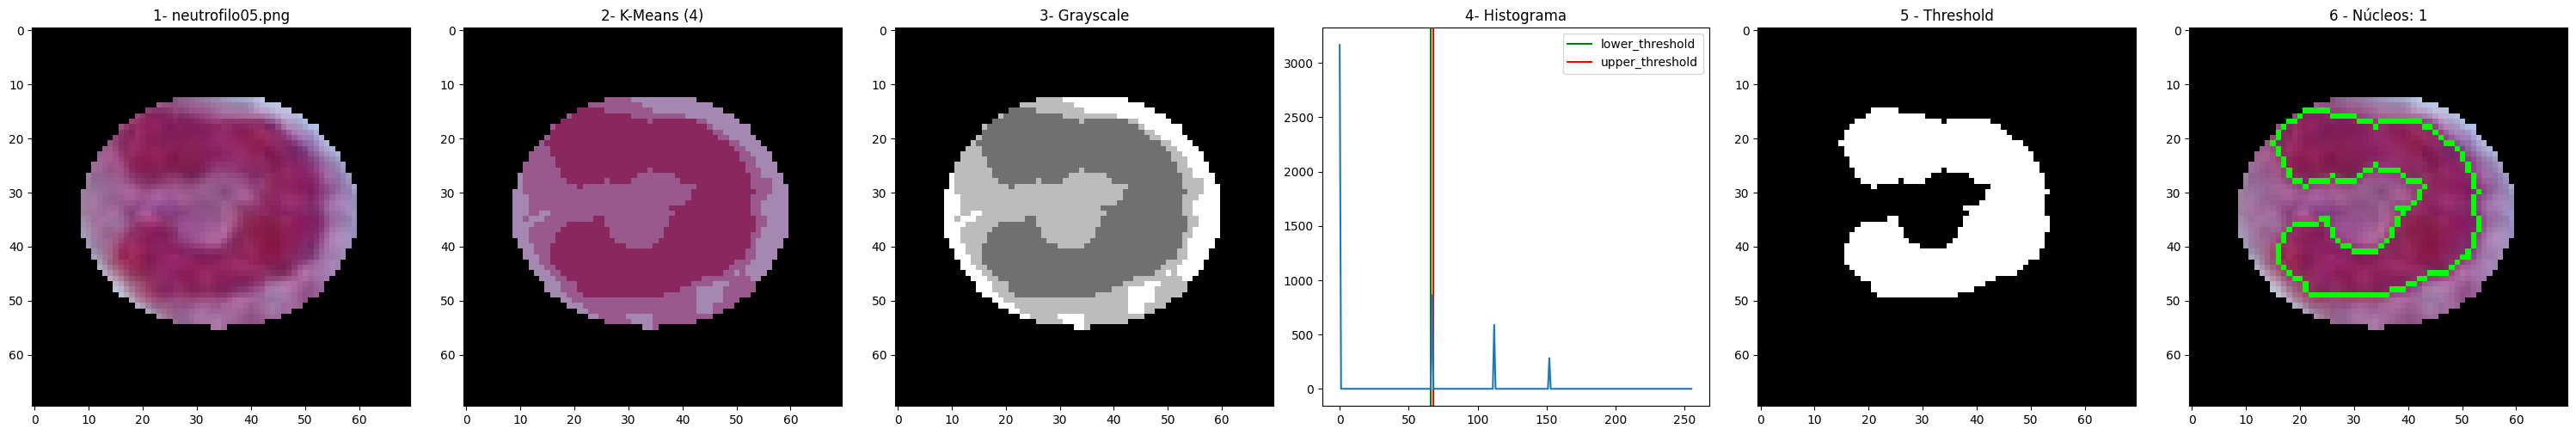

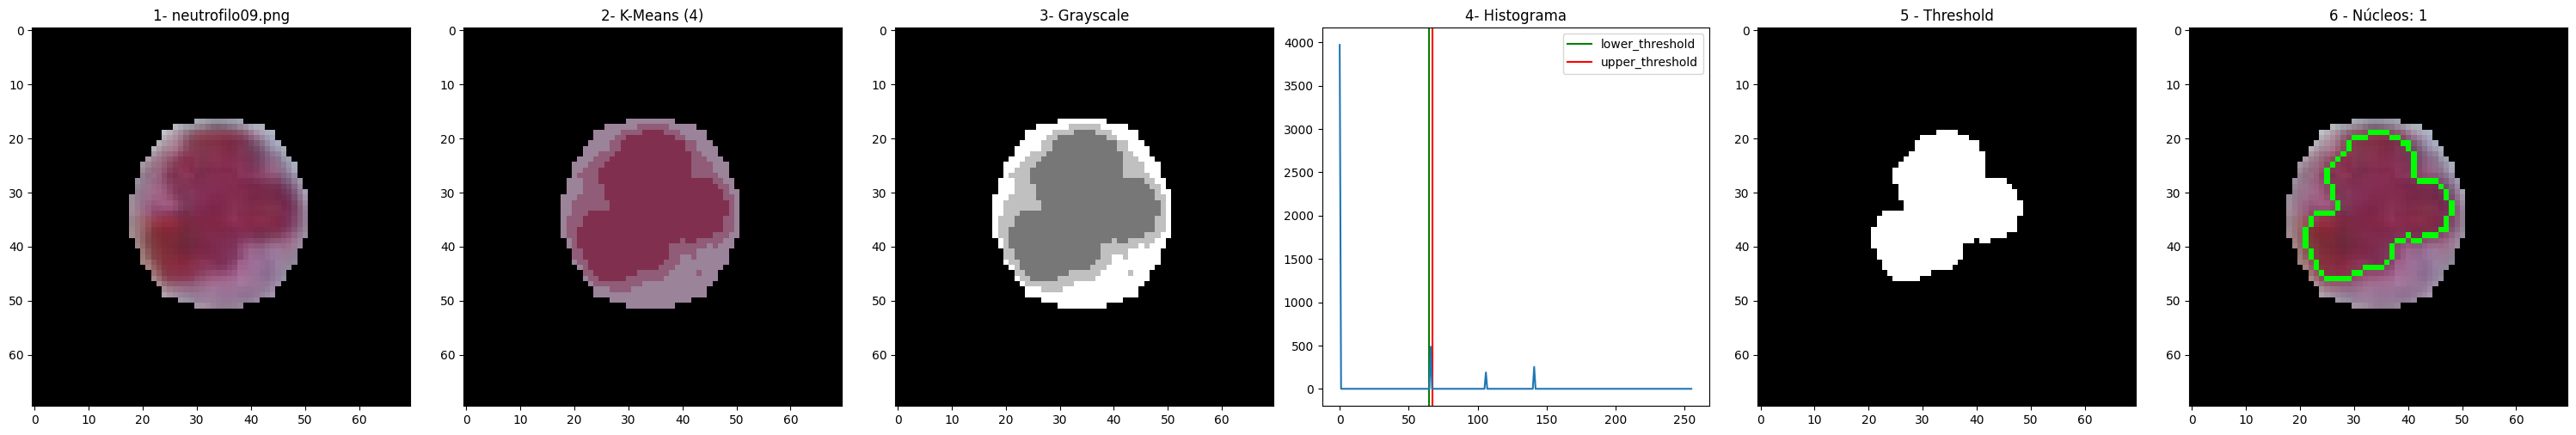

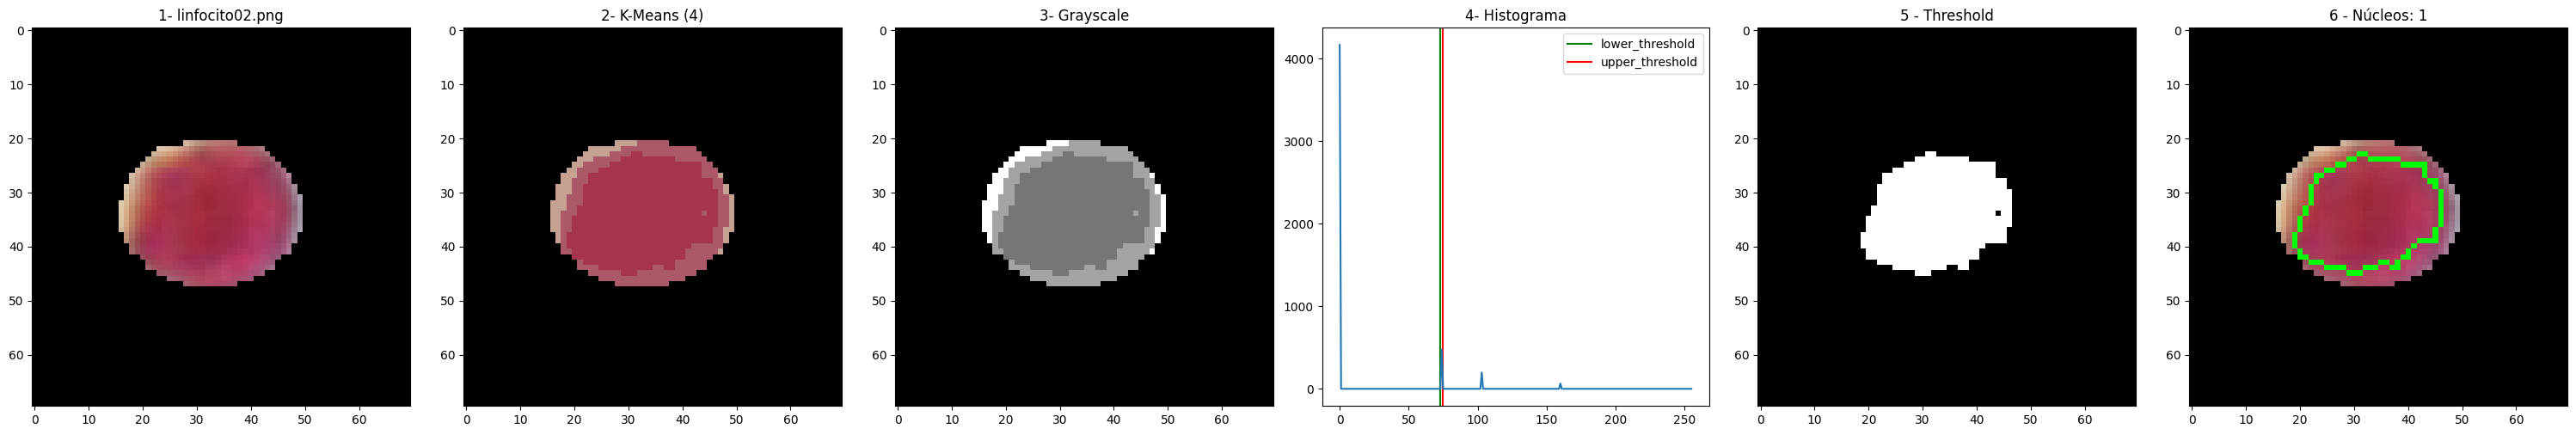

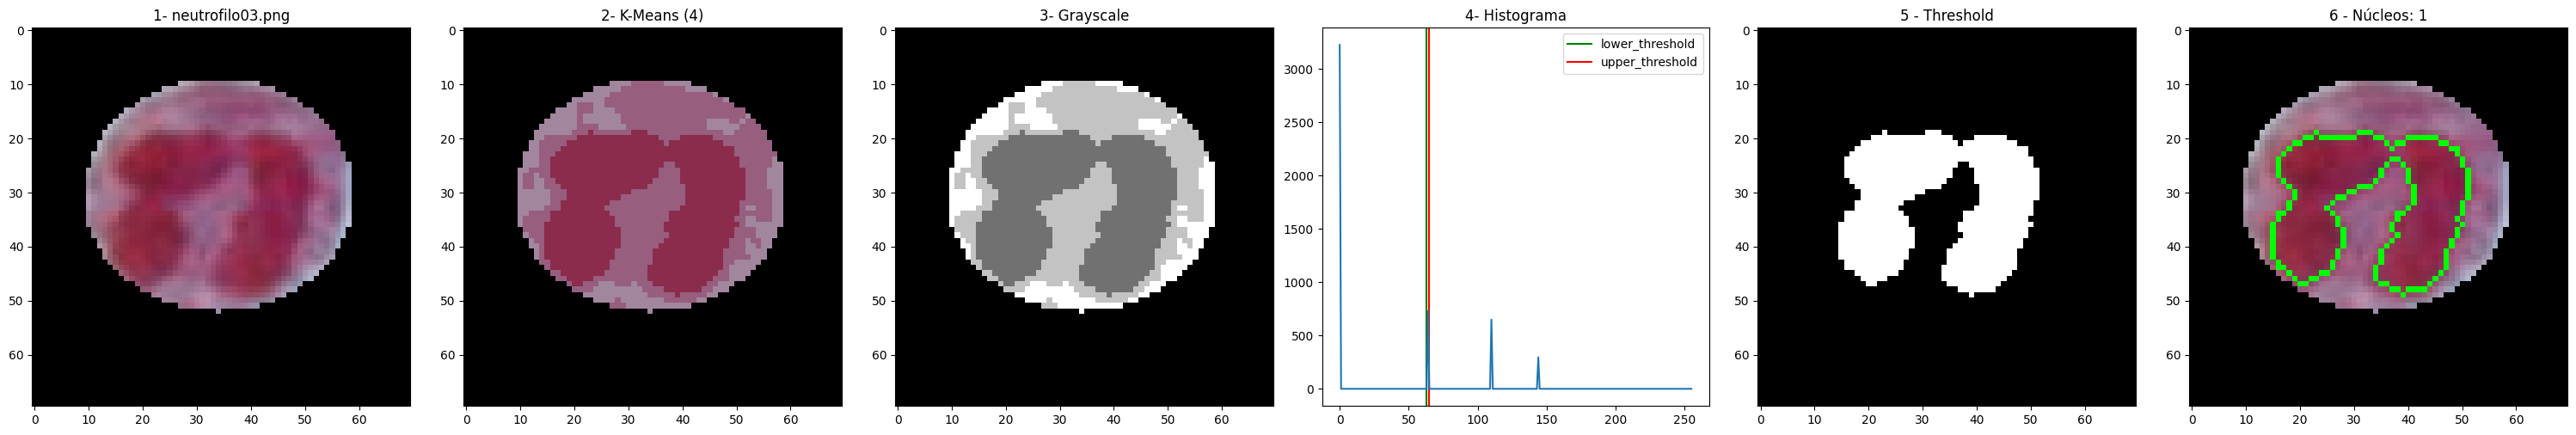

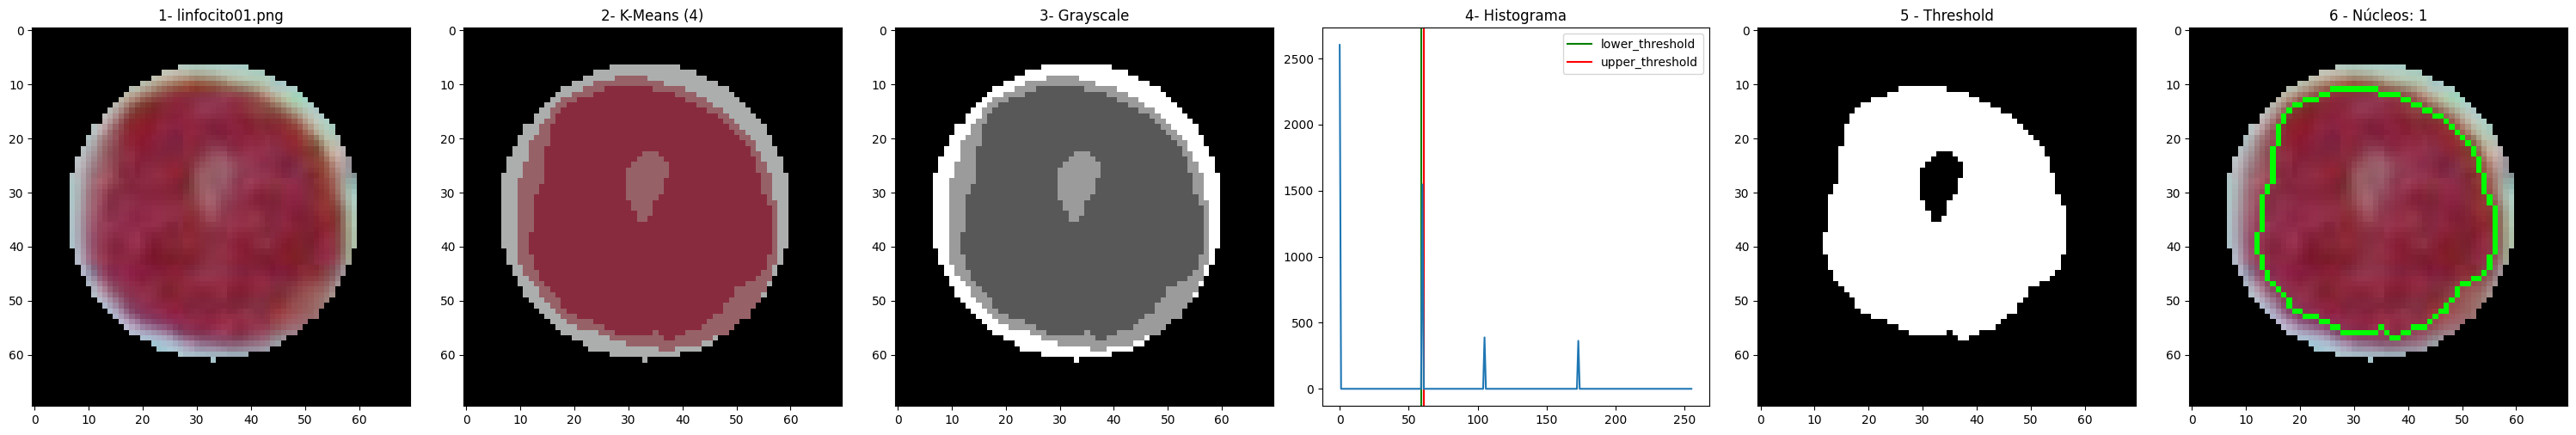

In [54]:
path_datasets = "imgs"
file_names = os.listdir(path_datasets)

for file_name in file_names:
    fig, axs = plt.subplots(1, 6)
    fig.set_figheight(5)
    fig.set_figwidth(30)
    img_path = os.path.join(path_datasets, file_name)

    img = cv.imread(img_path)
    axs[0].set_title("1- " + file_name)
    axs[0].imshow(img)

    Z = img.reshape((-1,3))
    Z = np.float32(Z)

    #Dilate na imagem remove alguns pontos muito pequenos que acabavam sendo processados como mini núcleos
    kernel = np.ones((5, 5), np.uint8)
    img_dilated = cv.dilate(img, kernel, iterations=1)

    #Doc de base do OpenCV: https://docs.opencv.org/3.4/d1/d5c/tutorial_py_kmeans_opencv.html
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 4
    ret, label, center = cv.kmeans(Z, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img_dilated.shape))
    axs[1].set_title("2- K-Means (" + str(K) + ")")
    axs[1].imshow(res2)

    axs[2].set_title("3- Grayscale")
    img_grayscale = cv.cvtColor(res2, cv.COLOR_BGR2GRAY)
    axs[2].imshow(img_grayscale, cmap = "gray")

    #Base em https://pyimagesearch.com/2021/04/28/opencv-image-histograms-cv2-calchist/
    hist = cv.calcHist([img_grayscale], [0], None, [256], [0, 256])

    #Pega o tom do cinza mais escuro que aparece no histograma - que representa os núcleos - e usa como bounds do threshold
    colors_hist = np.nonzero(hist.flatten())[0]
    first_gray = colors_hist[1]
    lower_threshold = float(first_gray - 1)
    upper_threshold = float(first_gray + 1)

    axs[3].set_title('4- Histograma')
    axs[3].axvline(x = lower_threshold, color = "g", label = "lower_threshold")
    axs[3].axvline(x = upper_threshold, color = "r", label = "upper_threshold")
    axs[3].legend()
    axs[3].plot(hist)

    thresholded_img = cv.inRange(img_grayscale, lower_threshold, upper_threshold)
    axs[4].set_title("5 - Threshold")
    axs[4].imshow(thresholded_img, cmap = "gray")

    contours, hierarchy = cv.findContours(thresholded_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    #As vezes, mesmo com dilatação, sobram alguns pedaços muito pequenos que são considerados núcleos.
    #Aqui eliminamos os pequenos demais para serem considerados - menores de 2% da área da imagem
    height, width = img.shape[:2]
    min_core_size = int(height * width * 0.02)

    valid_countors = []
    for contour in contours:
      contour_area = cv.contourArea(contour)
      if contour_area >= min_core_size:
        valid_countors.append(contour)

    img_contours = cv.drawContours(img, valid_countors, -1, (0, 255, 0), 1)
    axs[5].set_title("6 - Núcleos: " + str(len(valid_countors)))
    axs[5].imshow(img_contours)

    plt.tight_layout(pad = 0.5, w_pad = 0.5, h_pad = 2)